# FAA/Esri Airports NOTAM Status Living Atlas Layer 

**September 29th, 2017**

**Version 0.4**

*Documentation and Guidelines by Matthew Thompson, FAA*

*Notebook, Scripted Process, and Testing by Alberto Nieto, Esri*


### Purpose:
To help fulfill FAA objectives by outlining potential data sources and techniques to generate a real-time, data rich layer within Esri’s Living Atlas using the Python API for ArcGIS.

### End Goal:
The end goal of the project should be to have all ICAO coded public use airports in the United States as points available in Living Atlas as a feature service. Weather and NOTAM information should be available as attribute data to each airport. Additionally, NOTAM data should be parsed to populate an additional attribute field for “Airport NOTAM Status” indicating if the airport has a NOTAM issued that may affect the status of the airport.

### Data Parsing

#### National Flight Data Center (NFDC APT)
NFDC data is updated every 28 days and available for download as a fixed field width text file. File reference documentation is available on the NFDC website. This project will only make use of “APT” records in the APT file. Only ICAO coded, public use airports will be used in this phase. The following pseudo code should provide the necessary output to map the desired airports. 

~~~~
Select LOCATION IDENTIFIER, ICAO IDENTIFIER, OFFICIAL FACILITY NAME, AIRPORT REFERENCE POINT LATITUDE (FORMATTED), AIRPORT REFERENCE POINT LONGITUDE (FORMATTED)
From NFDC APT File
Where (
LANDING FACILITY TYPE = “Airport” AND
FACILITY USE = “PU” AND
ICAO IDENTIFIER IS NOT NULL)
~~~~

Of course, any additional information that may be useful can also be retained in the layer. Output of the above latitude and longitude will be used for feature position in the layer.

#### Aviation Digital Data Service (METARs)
METAR information should be added to the above features using ADDS data. METAR information is generated hourly. There are multiple search criteria available on the ADDS website. The stationString on in ADDS corresponds to the ICAO Identifier of the feature earlier identified. It is preferred that METAR information is available as both current and previous in the attribute data, in separate fields.

#### Aviation Digital Data Service (TAFs):
TAF information should be added to the above features using ADDS data. TAF information is generated daily. There are multiple search criteria available on the ADDS website. The stationString on in ADDS corresponds to the ICAO Identifier of the feature earlier identified. Only the current TAF is required.

#### Aeronautical Information Data Access Portal (AIDAP) Notice to Airmen (NOTAM) Data:
NOTAM information should be added to the above features using AIDAP data procured in the development teams preferred fashion (Java or WS). Association of the AIDAP provided NOTAMs should be based upon ICAO Identifier of the feature earlier identified. NOTAM information is purely text and can be several dozen messages, and may need to be handled in multiple fields, or in a fashion other than pure attribute of the feature. Examples of NOTAM information can be found by visiting https://pilotweb.nas.faa.gov and entering ICAO Identifiers in the “NOTAM Retrieval”, “Locations” section and clicking “View NOTAMs”.

#### Parsing NOTAMs for closure:
NOTAMs contain valuable information about the status of the airport in question. It would be exceptionally beneficial if the layer had an automatically derived Airport NOTAM Status field available. The proposed values for this field are:
•	Open
•	Closed
•	Limited

This is exceptionally complicated. The key term to search for in NOTAMs to identify if they will trigger this status is “AD AP CLSD”, however, the presence of “AD AP CLSD” does not necessarily trigger the field to full “Closed” status. The text immediately following “AD AP CLSD” will dictate if the status field receives a “Closed” or “Limited” status.

If, immediately following “AD AP CLSD” there is a space followed by a numeric string ten characters long, the airport receives a “Closed” status.

If, immediately following “AD AP CLSD” there is anything other than the previously mentioned string, the airport receives a “Limited” status.

#### Examples:

NOTAM:
!AGS 03/034 AGS AD AP CLSD TO FREIGHT, MEDICAL, AIR CARGO, AND FORMATION FLT 1704031200-1704112200
Automatic Status: Limited

NOTAM:
!WYS 11/004 WYS AD AP CLSD EXC LIFE FLT HEL 1611172345-1705152359EST
Automatic Status: Limited

NOTAM:
!FDR 03/002 FDR AD AP CLSD 1703281316-1704122359
Automatic Status: Closed

NOTAM:
!TEX 03/023 TEX AD AP CLSD 1704030300-1706251300
Automatic Status: Closed

An airport without a NOTAM containing “AD AP CLSD” receives the automatic status of “Open”.

## Execution of Scripted Process

### Core Data Download and Parsing: NFDC APT

NFDC data is updated every 28 days and available for download as a fixed field width text file. File reference documentation is available on the NFDC website. This project will only make use of “APT” records in the APT file. Only ICAO coded, public use airports will be used in this phase. The following pseudo code should provide the necessary output to map the desired airports. 

~~~~
Select LOCATION IDENTIFIER, ICAO IDENTIFIER, OFFICIAL FACILITY NAME, AIRPORT REFERENCE POINT LATITUDE (FORMATTED), AIRPORT REFERENCE POINT LONGITUDE (FORMATTED)
From NFDC APT File
Where (
LANDING FACILITY TYPE = “Airport” AND
FACILITY USE = “PU” AND
ICAO IDENTIFIER IS NOT NULL)
~~~~

Of course, any additional information that may be useful can also be retained in the layer. Output of the above latitude and longitude will be used for feature position in the layer.

In [77]:
# Import needed modules to download the APT file
import requests
import zipfile
import io
import datetime
import os
import getpass

In [4]:
# Test of loading of NFDC-APT file
apt_url = r"https://nfdc.faa.gov/webContent/28DaySub/2017-06-22/APT.zip"
inputs_dir = r"C:\Users\albe9057\Documents\ANieto_SolutionEngineering\Projects\DOT\FAA\FAA_LivingAtlas_Layer\Inputs\NFDC_NASR_APT"

In [5]:
# Download and unzip the apt_zip
response = requests.get(apt_url)
zipDocument = zipfile.ZipFile(io.BytesIO(response.content))
zipDocument.extractall(path=inputs_dir)
apt_file = "{0}\\{1}".format(inputs_dir, "apt.txt")

In [6]:
apt_file

'C:\\Users\\albe9057\\Documents\\ANieto_SolutionEngineering\\Projects\\DOT\\FAA\\FAA_LivingAtlas_Layer\\Inputs\\NFDC_NASR_APT\\apt.txt'

#### Set APT Schema
Schema documentation for APT fixed-width-file from FAA found at: 
https://nfdc.faa.gov/webContent/28DaySub/2017-06-22/Layout_Data/apt_rf.txt

In [7]:
apt_file_schema = {
    "apt": {
        "record_type_indicator": (0, 3),
        "landing_facility_site_number": (3, 14),
        "landing_facility_type": (14, 27),
        "location_identifier": (27, 31),
        "information_effective_date": (31, 41),
        "faa_region_code": (41, 44),
        "faa_district_or_field_office_code": (44, 48),
        "associated_state_post_office_code": (48, 50),
        "associated_state_name": (50, 70),
        "associated_county_name": (70, 91),
        "associated_county_state": (91, 93),
        "associated_city_name": (93, 133),
        "official_facility_name": (133, 183),
        "airport_ownership_type": (183, 185),
        "facility_use": (185, 187),
        "facility_owner_name": (187, 222),
        "owner_address": (222, 294),
        "owner_city_state_zip": (294, 339),
        "owner_phone_number": (339, 355),
        "facility_manager_name": (355, 390),
        "manager_address": (390, 462),
        "manager_city_state_zip": (462, 507),
        "manager_phone_number": (507, 523),
        "airport_reference_point_latitude_formatted": (523, 538),
        "airport_reference_point_latitude_seconds": (538, 550),
        "airport_reference_point_longitude_formatted": (550, 565),
        "airport_reference_point_longitude_seconds": (565, 577),
        "airport_reference_point_determination_method": (577, 578),
        "airport_elevation": (578, 585),
        "airport_elevation_determination_method": (585, 586),
        "magnetic_variation_and_direction": (586, 589),
        "magnetic_variation_epoch_year": (589, 593),
        "traffic_pattern_altitude": (593, 597),
        "aeronautical_sectional_chart": (597, 627),
        "distance_from_cbd_of_associated_city": (627, 629),
        "land_area_covered_by_airport": (632, 637),
        "boundary_artcc_identifier": (637, 641),
        "boundary_artcc_computer_identifier": (641, 644),
        "boundary_artcc_name": (644, 674),
        "responsible_artcc_identifier": (674, 678),
        "responsible_artcc_computer_identifier": (678, 681),
        "responsible_artcc_name": (680, 711),
        "tiein_fss_physically_located_on_facility": (711, 712),
        "tiein_fss_identifier": (712, 716),
        "tiein_fss_name": (715, 746),
        "local_phone_number_from_airport_to_fss": (746, 762),
        "tollfree_phone_number_from_airport_to_fss": (762, 778),
        "alternate_fss_identifier": (778, 782),
        "alternate_fss_name": (782, 812),
        "tollfree_phone_number_from_airport_to_altfss": (812, 828),
        "identifier_of_facility_resp_for_notams_and_weather": (828, 832),
        "availability_of_notam_d_service": (832, 833),
        "airport_activation_date": (833, 840),
        "airport_status_code": (840, 842),
        "airport_arff_cert_type_and_date": (842, 857),
        "npias_federal_agreements_code": (857, 864),
        "airport_airspace_analysis_determination": (864, 877),
        "ustreasury_desig_as_interntl_entry_for_customs": (877, 878),
        "ustreasury_desig_as_customs_landing_rights": (878, 879),
        "has_military_civil_joint_use_agrmnt": (879, 880),
        "airport_has_agrmnt_grants_military_landing_rights": (880, 881),
        "airport_inspection_method": (881, 883),
        "agency_performing_physical_inspection": (883, 884),
        "last_physical_inspection_date": (884, 892),
        "last_date_information_request_completed_by_mgr": (892, 900),
        "fuel_types_available": (900, 940),
        "airframe_repair_service_availability": (940, 945),
        "powerplant_engine_repair_availability": (945, 950),
        "type_of_bottled_oxygen_available": (950, 958),
        "type_of_bulk_oxygen_available": (958, 966),
        "airport_lighting_schedule": (966, 973),
        "beacon_lighting_schedule": (973, 980),
        "air_traffic_control_twr_located_on_airport": (980, 981),
        "unicom_freq_available_at_airport": (981, 988),
        "common_traffic_advisory_freq": (988, 995),
        "segmtd_circle_airport_marker_system": (995, 999),
        "lens_color_of_operable_beacon": (999, 1002),
        "landing_fee_charged_to_noncommercial_users": (1002, 1003),
        "used_for_medical_purposes": (1002, 1004),
        "single_engine_gen_aviation_aircraft": (1004, 1007),
        "multi_engine_gen_aviation_aircraft": (1007, 1010),
        "jet_enging_gen_aviation_aircraft": (1010, 1013),
        "gen_aviation_helicopter": (1013, 1016),
        "operational_gliders": (1016, 1019),
        "operational_military_aircraft": (1019, 1022),
        "ultralight_aircraft": (1022, 1025),
        "commercial_services": (1025, 1031),
        "commuter_services": (1031, 1037),
        "air_taxi": (1037, 1043),
        "gen_aviation_local_ops": (1043, 1049),
        "gen_aviation_itinerant_ops": (1049, 1055),
        "military_aircraft_ops": (1055, 1061),
        "reference_ending_date_for_ops_fields": (1061, 1071),
        "airport_position_source": (1071, 1087),
        "airport_position_source_date": (1087, 1097),
        "airport_elev_source": (1097, 1113),
        "airport_elev_source_date": (1113, 1123),
        "contract_fuel_available": (1123, 1124),
        "transient_storage_facilities": (1124, 1136),
        "other_airport_services_available": (1136, 1207),
        "wind_indicator": (1207, 1210),
        "icao_identifier": (1210, 1217),
        "airport_record_filler": (1217, 1218)
    }
}

In [8]:
# To get the specific record type of field character locations as a list:
apt_col_specs = list(apt_file_schema["apt"].values())
apt_col_specs

[(0, 3),
 (3, 14),
 (14, 27),
 (27, 31),
 (31, 41),
 (41, 44),
 (44, 48),
 (48, 50),
 (50, 70),
 (70, 91),
 (91, 93),
 (93, 133),
 (133, 183),
 (183, 185),
 (185, 187),
 (187, 222),
 (222, 294),
 (294, 339),
 (339, 355),
 (355, 390),
 (390, 462),
 (462, 507),
 (507, 523),
 (523, 538),
 (538, 550),
 (550, 565),
 (565, 577),
 (577, 578),
 (578, 585),
 (585, 586),
 (586, 589),
 (589, 593),
 (593, 597),
 (597, 627),
 (627, 629),
 (632, 637),
 (637, 641),
 (641, 644),
 (644, 674),
 (674, 678),
 (678, 681),
 (680, 711),
 (711, 712),
 (712, 716),
 (715, 746),
 (746, 762),
 (762, 778),
 (778, 782),
 (782, 812),
 (812, 828),
 (828, 832),
 (832, 833),
 (833, 840),
 (840, 842),
 (842, 857),
 (857, 864),
 (864, 877),
 (877, 878),
 (878, 879),
 (879, 880),
 (880, 881),
 (881, 883),
 (883, 884),
 (884, 892),
 (892, 900),
 (900, 940),
 (940, 945),
 (945, 950),
 (950, 958),
 (958, 966),
 (966, 973),
 (973, 980),
 (980, 981),
 (981, 988),
 (988, 995),
 (995, 999),
 (999, 1002),
 (1002, 1003),
 (1002, 1

In [9]:
apt_col_names = list(apt_file_schema["apt"].keys())
apt_col_names

['record_type_indicator',
 'landing_facility_site_number',
 'landing_facility_type',
 'location_identifier',
 'information_effective_date',
 'faa_region_code',
 'faa_district_or_field_office_code',
 'associated_state_post_office_code',
 'associated_state_name',
 'associated_county_name',
 'associated_county_state',
 'associated_city_name',
 'official_facility_name',
 'airport_ownership_type',
 'facility_use',
 'facility_owner_name',
 'owner_address',
 'owner_city_state_zip',
 'owner_phone_number',
 'facility_manager_name',
 'manager_address',
 'manager_city_state_zip',
 'manager_phone_number',
 'airport_reference_point_latitude_formatted',
 'airport_reference_point_latitude_seconds',
 'airport_reference_point_longitude_formatted',
 'airport_reference_point_longitude_seconds',
 'airport_reference_point_determination_method',
 'airport_elevation',
 'airport_elevation_determination_method',
 'magnetic_variation_and_direction',
 'magnetic_variation_epoch_year',
 'traffic_pattern_altitude',

In [10]:
len(apt_col_names)

103

#### NFDC APT Data Parsing and Loading to GIS

In [11]:
import pandas as pd

In [12]:
df = pd.read_fwf(apt_file, header=None, names=apt_col_names, colspecs=apt_col_specs)

In [13]:
df.head()

,record_type_indicator,landing_facility_site_number,landing_facility_type,location_identifier,information_effective_date,faa_region_code,faa_district_or_field_office_code,associated_state_post_office_code,associated_state_name,associated_county_name,...,airport_position_source,airport_position_source_date,airport_elev_source,airport_elev_source_date,contract_fuel_available,transient_storage_facilities,other_airport_services_available,wind_indicator,icao_identifier,airport_record_filler
0,APT,50009.*A,AIRPORT,ADK,06/22/2017,AAL,NONE,AK,ALASKA,ALEUTIANS WEST,...,3RD PARTY SURVEY,07/17/2011,3RD PARTY SURVEY,07/17/2011,NaN,HGR,CARGO,Y,PADK,NaN
1,ATT,50009.*A,AK 1ALL/ALL/0,800-,1600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RWY,50009.*A,AK05/23 779,0 20,0ASPH-F,NaN,GRVD,4,9 /R/B/X/THIGH 05 06,1 YNPI G51-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RMK,50009.*A,AKA110-11,PS,BL WIND SH,EAR,S LN,DG,/DEPARTING ALL RYS.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RMK,50009.*A,AKA110-14,AL,L RWYS GRV,D;,DO N,OT,MAKE LOCKED-BRAKE T,URNS.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.shape

(139822, 103)

In [15]:
# Parse the file for records beginning with "APT*"
apt_df = df.loc[df["record_type_indicator"].str.contains("APT")]
del df

In [16]:
apt_df.head()

,record_type_indicator,landing_facility_site_number,landing_facility_type,location_identifier,information_effective_date,faa_region_code,faa_district_or_field_office_code,associated_state_post_office_code,associated_state_name,associated_county_name,...,airport_position_source,airport_position_source_date,airport_elev_source,airport_elev_source_date,contract_fuel_available,transient_storage_facilities,other_airport_services_available,wind_indicator,icao_identifier,airport_record_filler
0,APT,50009.*A,AIRPORT,ADK,06/22/2017,AAL,NONE,AK,ALASKA,ALEUTIANS WEST,...,3RD PARTY SURVEY,07/17/2011,3RD PARTY SURVEY,07/17/2011,NaN,HGR,CARGO,Y,PADK,NaN
20,APT,50016.1*A,AIRPORT,AKK,06/22/2017,AAL,NONE,AK,ALASKA,KODIAK ISLAND,...,NACO,03/18/1997,NACO,03/18/1997,NaN,NaN,NaN,Y,PAKH,NaN
29,APT,50017.*A,AIRPORT,Z13,06/22/2017,AAL,NONE,AK,ALASKA,BETHEL,...,STATE,12/02/2013,STATE,12/02/2013,NaN,NaN,CARGO,Y-L,NaN,NaN
37,APT,50017.1*C,SEAPLANE BASE,KKI,06/22/2017,AAL,NONE,AK,ALASKA,BETHEL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN
49,APT,50020.*A,AIRPORT,AKI,06/22/2017,AAL,NONE,AK,ALASKA,BETHEL,...,STATE,09/15/2014,STATE,09/15/2014,NaN,NaN,CARGO,Y-L,PFAK,NaN


In [17]:
apt_df.loc[0]

record_type_indicator                                                       APT
landing_facility_site_number                                           50009.*A
landing_facility_type                                                   AIRPORT
location_identifier                                                         ADK
information_effective_date                                           06/22/2017
faa_region_code                                                             AAL
faa_district_or_field_office_code                                          NONE
associated_state_post_office_code                                            AK
associated_state_name                                                    ALASKA
associated_county_name                                           ALEUTIANS WEST
associated_county_state                                                      AK
associated_city_name                                                ADAK ISLAND
official_facility_name                  

In [18]:
apt_df.shape

(19765, 103)

##### Needed query:
~~~~
Select LOCATION IDENTIFIER, ICAO IDENTIFIER, OFFICIAL FACILITY NAME, AIRPORT REFERENCE POINT LATITUDE (FORMATTED), AIRPORT REFERENCE POINT LONGITUDE (FORMATTED)
From NFDC APT File
Where (
LANDING FACILITY TYPE = “Airport” AND
FACILITY USE = “PU” AND
ICAO IDENTIFIER IS NOT NULL)
~~~~

In [19]:
# Create a list of fields that are needed for the core APT file
fields_needed = ["location_identifier", 
                 "icao_identifier", 
                 "official_facility_name", 
                 "airport_reference_point_latitude_formatted", 
                 "airport_reference_point_longitude_formatted"]

In [20]:
# Check which landing facility type values are currently in the file
apt_df.landing_facility_type.unique()

array(['AIRPORT', 'SEAPLANE BASE', 'HELIPORT', 'GLIDERPORT', 'ULTRALIGHT',
       'BALLOONPORT'], dtype=object)

In [21]:
# Check which facility use values are currently in the file
apt_df.facility_use.unique()

array(['PU', 'PR'], dtype=object)

In [22]:
# Create a dataframe using the needed query above
apt_filtered_df = apt_df[(apt_df.landing_facility_type == "AIRPORT") & (apt_df.facility_use == "PU") & (apt_df.icao_identifier.notnull())]

In [23]:
apt_df.shape

(19765, 103)

In [24]:
apt_filtered_df.shape

(2439, 103)

In [25]:
apt_filtered_df

,record_type_indicator,landing_facility_site_number,landing_facility_type,location_identifier,information_effective_date,faa_region_code,faa_district_or_field_office_code,associated_state_post_office_code,associated_state_name,associated_county_name,...,airport_position_source,airport_position_source_date,airport_elev_source,airport_elev_source_date,contract_fuel_available,transient_storage_facilities,other_airport_services_available,wind_indicator,icao_identifier,airport_record_filler
0,APT,50009.*A,AIRPORT,ADK,06/22/2017,AAL,NONE,AK,ALASKA,ALEUTIANS WEST,...,3RD PARTY SURVEY,07/17/2011,3RD PARTY SURVEY,07/17/2011,NaN,HGR,CARGO,Y,PADK,NaN
20,APT,50016.1*A,AIRPORT,AKK,06/22/2017,AAL,NONE,AK,ALASKA,KODIAK ISLAND,...,NACO,03/18/1997,NACO,03/18/1997,NaN,NaN,NaN,Y,PAKH,NaN
49,APT,50020.*A,AIRPORT,AKI,06/22/2017,AAL,NONE,AK,ALASKA,BETHEL,...,STATE,09/15/2014,STATE,09/15/2014,NaN,NaN,CARGO,Y-L,PFAK,NaN
67,APT,50022.1*A,AIRPORT,7AK,06/22/2017,AAL,NONE,AK,ALASKA,ALEUTIANS EAST,...,STATE,11/17/2014,3RD PARTY SURVEY,10/03/2012,NaN,NaN,NaN,Y-L,PAUT,NaN
76,APT,50024.1*A,AIRPORT,AUK,06/22/2017,AAL,NONE,AK,ALASKA,WADE HAMPTON,...,3RD PARTY SURVEY,12/14/2012,3RD PARTY SURVEY,12/14/2012,NaN,TIE,CARGO,Y-L,PAUK,NaN
127,APT,50029.1*A,AIRPORT,6A8,06/22/2017,AAL,NONE,AK,ALASKA,YUKON-KOYUKUK,...,3RD PARTY SURVEY,07/02/2005,3RD PARTY SURVEY,07/02/2005,NaN,TIE,NaN,Y-L,PFAL,NaN
138,APT,50029.61*A,AIRPORT,AFM,06/22/2017,AAL,NONE,AK,ALASKA,NORTHWEST ARCTIC,...,FAA,09/25/2015,3RD PARTY SURVEY,06/17/2012,NaN,TIE,CHTR,Y-L,PAFM,NaN
163,APT,50032.*A,AIRPORT,AKP,06/22/2017,AAL,NONE,AK,ALASKA,YUKON-KOYUKUK,...,3RD PARTY SURVEY,06/20/2012,3RD PARTY SURVEY,06/20/2012,NaN,TIE,NaN,N,PAKP,NaN
259,APT,50034.*A,AIRPORT,ANC,06/22/2017,AAL,NONE,AK,ALASKA,ANCHORAGE,...,3RD PARTY SURVEY,04/09/2012,3RD PARTY SURVEY,04/09/2012,NaN,"HGR,TIE",CARGO,Y-L,PANC,NaN
284,APT,50035.*A,AIRPORT,MRI,06/22/2017,AAL,NONE,AK,ALASKA,ANCHORAGE,...,FAA-EST,04/28/2011,NACO,07/09/2003,NaN,"HGR,TIE","AFRT,AMB,AVNCS,CARGO,CHTR,INSTR,RNTL,SALES,SURV",Y-L,PAMR,NaN


In [26]:
# Retrieve only the needed fields from the filtered dataframe
apt_final_df = apt_filtered_df[fields_needed]

In [27]:
apt_final_df

,location_identifier,icao_identifier,official_facility_name,airport_reference_point_latitude_formatted,airport_reference_point_longitude_formatted
0,ADK,PADK,ADAK,51-53-00.8954N,176-38-32.9277W
20,AKK,PAKH,AKHIOK,56-56-19.2870N,154-10-57.2000W
49,AKI,PFAK,AKIAK,60-54-10.4300N,161-13-50.1000W
67,7AK,PAUT,AKUTAN,54-08-40.6000N,165-36-14.7900W
76,AUK,PAUK,ALAKANUK,62-40-59.0000N,164-43-19.9000W
127,6A8,PFAL,ALLAKAKET,66-33-06.6000N,152-37-19.8000W
138,AFM,PAFM,AMBLER,67-06-22.3282N,157-51-25.8151W
163,AKP,PAKP,ANAKTUVUK PASS,68-08-01.0000N,151-44-36.0000W
259,ANC,PANC,TED STEVENS ANCHORAGE INTL,61-10-26.9634N,149-59-53.4791W
284,MRI,PAMR,MERRILL FIELD,61-12-48.7622N,149-50-41.0069W


#### Format Latitude and Longitude Values

Helper functions for conversion of decimal minutes seconds to decimal degrees

In [28]:
import re

def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'E' or direction == 'N':
        dd *= -1
    return dd

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])

    return (lat)

# Establish a quick helper function to calculate negative values across numpy/pandas array
def convert_to_neg(longitude_string):
    return "-{0}".format(longitude_string)

In [29]:
test_lat = "60-54-10.4300N"

In [30]:
parse_dms(test_lat)

60.90277777777778

In [31]:
apt_final_df["latitude_dd"] = apt_final_df.apply(lambda x: parse_dms(x["airport_reference_point_latitude_formatted"]), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
apt_final_df["longitude_dd"] = apt_final_df.apply(lambda x: parse_dms(x["airport_reference_point_longitude_formatted"]), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
apt_final_df["longitude_dd"] = apt_final_df.apply(lambda x: convert_to_neg(x["longitude_dd"]), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
apt_final_df

,location_identifier,icao_identifier,official_facility_name,airport_reference_point_latitude_formatted,airport_reference_point_longitude_formatted,latitude_dd,longitude_dd
0,ADK,PADK,ADAK,51-53-00.8954N,176-38-32.9277W,51.883333,-176.64222222222222
20,AKK,PAKH,AKHIOK,56-56-19.2870N,154-10-57.2000W,56.938611,-154.1825
49,AKI,PFAK,AKIAK,60-54-10.4300N,161-13-50.1000W,60.902778,-161.23055555555555
67,7AK,PAUT,AKUTAN,54-08-40.6000N,165-36-14.7900W,54.144444,-165.6038888888889
76,AUK,PAUK,ALAKANUK,62-40-59.0000N,164-43-19.9000W,62.683056,-164.72194444444446
127,6A8,PFAL,ALLAKAKET,66-33-06.6000N,152-37-19.8000W,66.551667,-152.62194444444447
138,AFM,PAFM,AMBLER,67-06-22.3282N,157-51-25.8151W,67.106111,-157.85694444444445
163,AKP,PAKP,ANAKTUVUK PASS,68-08-01.0000N,151-44-36.0000W,68.133611,-151.7433333333333
259,ANC,PANC,TED STEVENS ANCHORAGE INTL,61-10-26.9634N,149-59-53.4791W,61.173889,-149.99805555555554
284,MRI,PAMR,MERRILL FIELD,61-12-48.7622N,149-50-41.0069W,61.213333,-149.84472222222223


#### Export dataframe to local csv

In [35]:
inputs_dir

'C:\\Users\\albe9057\\Documents\\ANieto_SolutionEngineering\\Projects\\DOT\\FAA\\FAA_LivingAtlas_Layer\\Inputs\\NFDC_NASR_APT'

In [36]:
apt_final_df.set_index("icao_identifier", inplace=True)

In [37]:
apt_final_csv = "{0}//{1}".format(inputs_dir, "apt_formatted.csv")

In [38]:
apt_final_df.to_csv("{0}//{1}".format(inputs_dir, "apt_formatted.csv"))

##### At this stage, we have the APT core file queried and formatted in the desired manner. The next steps handle appending of METARs, TAFs, and AIDAP NOTAM data to this core file. 

### Data Load #1: ADDS (METARs)

METAR information should be added to the above features using ADDS data. METAR information is generated hourly. There are multiple search criteria available on the ADDS website. The stationString on in ADDS corresponds to the ICAO Identifier of the feature earlier identified. It is preferred that METAR information is available as both current and previous in the attribute data, in separate fields.

In [39]:
# Change our inputs directory to the METARs directory
inputs_dir = r"C:\Users\albe9057\Documents\ANieto_SolutionEngineering\Projects\DOT\FAA\FAA_LivingAtlas_Layer\Inputs\ADDS_METARs_TAFs"; inputs_dir

'C:\\Users\\albe9057\\Documents\\ANieto_SolutionEngineering\\Projects\\DOT\\FAA\\FAA_LivingAtlas_Layer\\Inputs\\ADDS_METARs_TAFs'

The following are helper functions to download and process METAR files

In [40]:
# Simple helper function for url download to local target path
def download_file(url, local_target_path):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(local_target_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                #f.flush() commented by recommendation from J.F.Sebastian
    return local_target_path

In [41]:
# Helper function to download an xml to a pandas dataframe
import xml.etree.ElementTree as ET

def xml_to_df(xml_data, child_tag):
    tree = ET.parse(xml_data)
    root = tree.getroot()
    all_records = []
    for i, child in enumerate(root):
        if child.tag == "data":
            for subchild in child:
                if subchild.tag == child_tag:
                    record = {}
                    for subsubchild in subchild:
                        record[subsubchild.tag] = subsubchild.text
                    all_records.append(record)
    return pd.DataFrame(all_records)

In [42]:
# METAR-specific helper function to append METAR for a ICAO value
def append_metar_for_icao_id(icao_val, apt_df, workspace_dir, hours_before_now=1, clean_up_temp_files=True):
    print("Processing METAR for '{0}'...".format(str(icao_val)))
    hours_before_now = 1
    metar_request_url = r"https://www.aviationweather.gov/adds/dataserver_current/httpparam?dataSource=metars&requestType=retrieve&format=xml&stationString={0}&hoursBeforeNow={1}&mostRecent=true".format(icao_val, hours_before_now)
    metars_temp_file = "{0}\\{1}".format(workspace_dir, "metar_{0}.xml".format(str(icao_val)))
    
    metars_temp_xml = download_file(metar_request_url, metars_temp_file) 

    metars_temp_df = xml_to_df(metars_temp_xml, "METAR")
                                         
    metars_temp_df['icao_identifier'] = icao_val
                                         
    metars_temp_df.set_index("icao_identifier", inplace=True)
                                         
    apt_df = apt_df.join(metars_df)
    
    apt_df = apt_df.merge(metars_df)
    
    return apt_df

In [43]:
# METAR-specific function to compile metars for multiple ICAO values
def compile_metars_for_all_icao_ids(icao_vals, workspace_dir, hours_before_now=1, clean_up_temp_files=True):
    # Set a container for each icao metar dataframe
    metars_panel = []
    # Iterate on each icao value
    for icao_val in icao_vals:
        # Attempt to process
        try:
            
            print("Processing METAR for '{0}'...".format(str(icao_val)))
            hours_before_now = 1
            metar_request_url = r"https://www.aviationweather.gov/adds/dataserver_current/httpparam?dataSource=metars&requestType=retrieve&format=xml&stationString={0}&hoursBeforeNow={1}&mostRecent=true".format(icao_val, hours_before_now)
            metars_temp_file = "{0}\\{1}".format(workspace_dir, "metar_{0}.xml".format(str(icao_val)))

            metars_temp_xml = download_file(metar_request_url, metars_temp_file) 

            metars_temp_df = xml_to_df(metars_temp_xml, "METAR")

            metars_temp_df['icao_identifier'] = icao_val

            metars_panel.append(metars_temp_df)
        
        # Handle exceptions
        except Exception as e:
            print("Error when attempting to download METAR for '{0}':".format(str(icao_val)))
#             print(e.message)
            print(e)

    # Using the final list of metar dataframes, concatenate into a single pandas dataframe
    metars_final_df = pd.concat(metars_panel)
    metars_final_df.set_index("icao_identifier", inplace=True)

    return metars_final_df

In [44]:
# Get unique ICAO values into a list
icao_vals = apt_final_df.index.values.tolist() ; icao_vals

['PADK',
 'PAKH',
 'PFAK',
 'PAUT',
 'PAUK',
 'PFAL',
 'PAFM',
 'PAKP',
 'PANC',
 'PAMR',
 'PANI',
 'PANV',
 'PARC',
 'PAAK',
 'PATQ',
 'PABR',
 'PABA',
 'PAWB',
 'PABE',
 'PABT',
 'PAGQ',
 'PABV',
 'PFKT',
 'PABL',
 'PATW',
 'PACE',
 'PACI',
 'PALR',
 'PACK',
 'PFCB',
 'PAVA',
 'PAJC',
 'PACH',
 'PACR',
 'PFCL',
 'PACL',
 'PACD',
 'PACX',
 'PACV',
 'PASC',
 'PADE',
 'PADL',
 'PAEG',
 'PAEE',
 'PAII',
 'PFEL',
 'PAEM',
 'PAAN',
 'PAFA',
 'PAKF',
 'PAFL',
 'PFYU',
 'PAGB',
 'PAGA',
 'PAGM',
 'PAGL',
 'PAGX',
 'PAGK',
 'PAGS',
 'PAHN',
 'PAHV',
 'PAHC',
 'PAHO',
 'PAOH',
 'PAHP',
 'PAHU',
 'PAHL',
 'PAIG',
 'PAIL',
 'PAJN',
 'PAFE',
 'PALG',
 'PAKV',
 'PAKY',
 'PFKA',
 'PAEN',
 'PAKT',
 'PAIK',
 'PAVC',
 'PAKN',
 'PAKI',
 'PAVL',
 'PAKW',
 'PAOB',
 'PAKD',
 'PADQ',
 'PFKK',
 'PAJZ',
 'PADY',
 'PFKO',
 'PAOT',
 'PAKK',
 'PFKU',
 'PAKL',
 'PFKW',
 'PAGG',
 'PALB',
 'PAMX',
 'PAMC',
 'PAIN',
 'PAML',
 'PAMB',
 'PADM',
 'PAMY',
 'PAMD',
 'PAMH',
 'PAMO',
 'PANA',
 'PAPK',
 'PAOU',
 'PANN',
 

In [45]:
len(icao_vals)

2439

In [46]:
# Execute the main metar download and compile sequence
metars_df = compile_metars_for_all_icao_ids(icao_vals, inputs_dir, hours_before_now=1, clean_up_temp_files=True)

Processing METAR for 'PADK'...
Processing METAR for 'PAKH'...
Processing METAR for 'PFAK'...
Processing METAR for 'PAUT'...
Processing METAR for 'PAUK'...
Processing METAR for 'PFAL'...
Processing METAR for 'PAFM'...
Processing METAR for 'PAKP'...
Processing METAR for 'PANC'...
Processing METAR for 'PAMR'...
Processing METAR for 'PANI'...
Processing METAR for 'PANV'...
Processing METAR for 'PARC'...
Processing METAR for 'PAAK'...
Processing METAR for 'PATQ'...
Processing METAR for 'PABR'...
Processing METAR for 'PABA'...
Processing METAR for 'PAWB'...
Processing METAR for 'PABE'...
Processing METAR for 'PABT'...
Processing METAR for 'PAGQ'...
Processing METAR for 'PABV'...
Processing METAR for 'PFKT'...
Processing METAR for 'PABL'...
Processing METAR for 'PATW'...
Processing METAR for 'PACE'...
Processing METAR for 'PACI'...
Processing METAR for 'PALR'...
Processing METAR for 'PACK'...
Processing METAR for 'PFCB'...
Processing METAR for 'PAVA'...
Processing METAR for 'PAJC'...
Processi

Processing METAR for 'KDUG'...
Processing METAR for 'KFLG'...
Processing METAR for 'KFHU'...
Processing METAR for 'KGEU'...
Processing METAR for 'KGYR'...
Processing METAR for 'KGCN'...
Processing METAR for 'KIGM'...
Processing METAR for 'KHII'...
Processing METAR for 'KMZJ'...
Processing METAR for 'KFFZ'...
Processing METAR for 'KOLS'...
Processing METAR for 'KPGA'...
Processing METAR for 'KPAN'...
Processing METAR for 'KDVT'...
Processing METAR for 'KIWA'...
Processing METAR for 'KPHX'...
Processing METAR for 'KPRC'...
Processing METAR for 'KSAD'...
Processing METAR for 'KSJN'...
Processing METAR for 'KSDL'...
Processing METAR for 'KSEZ'...
Processing METAR for 'KSOW'...
Processing METAR for 'KJTC'...
Processing METAR for 'KTYL'...
Processing METAR for 'KAVQ'...
Processing METAR for 'KTUS'...
Processing METAR for 'KRYN'...
Processing METAR for 'KCMR'...
Processing METAR for 'KRQE'...
Processing METAR for 'KINW'...
Processing METAR for 'KNYL'...
Processing METAR for 'KAAT'...
Processi

Processing METAR for 'KMIA'...
Processing METAR for 'KOPF'...
Processing METAR for 'KAPF'...
Processing METAR for 'KEVB'...
Processing METAR for 'KOCF'...
Processing METAR for 'KOBE'...
Processing METAR for 'KMCO'...
Processing METAR for 'KSFB'...
Processing METAR for 'KISM'...
Processing METAR for 'KORL'...
Processing METAR for 'KOMN'...
Processing METAR for 'KPHK'...
Processing METAR for 'KFIN'...
Processing METAR for 'KECP'...
Processing METAR for 'KPNS'...
Processing METAR for 'KPCM'...
Processing METAR for 'KPMP'...
Processing METAR for 'KPGD'...
Processing METAR for 'KSGJ'...
Processing METAR for 'KSPG'...
Processing METAR for 'KPIE'...
Processing METAR for 'KSRQ'...
Processing METAR for 'KSEF'...
Processing METAR for 'KSUA'...
Processing METAR for 'KTLH'...
Processing METAR for 'KTPA'...
Processing METAR for 'KVDF'...
Processing METAR for 'KTPF'...
Processing METAR for 'KTIX'...
Processing METAR for 'KVPS'...
Processing METAR for 'KVNC'...
Processing METAR for 'KVRB'...
Processi

Processing METAR for 'KMLI'...
Processing METAR for 'KAJG'...
Processing METAR for 'KMVN'...
Processing METAR for 'KOLY'...
Processing METAR for 'KPRG'...
Processing METAR for 'KPIA'...
Processing METAR for 'KVYS'...
Processing METAR for 'KPJY'...
Processing METAR for 'KPPQ'...
Processing METAR for 'KPNT'...
Processing METAR for 'KUIN'...
Processing METAR for 'KTIP'...
Processing METAR for 'KRSV'...
Processing METAR for 'KRPJ'...
Processing METAR for 'KRFD'...
Processing METAR for 'KSLO'...
Processing METAR for 'KSFY'...
Processing METAR for 'KSAR'...
Processing METAR for 'KSPI'...
Processing METAR for 'KSQI'...
Processing METAR for 'KTAZ'...
Processing METAR for 'KVLA'...
Processing METAR for 'KAID'...
Processing METAR for 'KANQ'...
Processing METAR for 'KGWB'...
Processing METAR for 'KHLB'...
Processing METAR for 'KBFR'...
Processing METAR for 'KBMG'...
Processing METAR for 'KBAK'...
Processing METAR for 'KCEV'...
Processing METAR for 'KCFJ'...
Processing METAR for 'KEKM'...
Processi

Processing METAR for 'KAPN'...
Processing METAR for 'KARB'...
Processing METAR for 'KBAX'...
Processing METAR for 'KBTL'...
Processing METAR for 'KSJX'...
Processing METAR for 'KACB'...
Processing METAR for 'KBEH'...
Processing METAR for 'KRQB'...
Processing METAR for 'KBFA'...
Processing METAR for 'KCAD'...
Processing METAR for 'KCFS'...
Processing METAR for 'KCVX'...
Processing METAR for 'KFPK'...
Processing METAR for 'KSLH'...
Processing METAR for 'KOEB'...
Processing METAR for 'KDET'...
Processing METAR for 'KONZ'...
Processing METAR for 'KDTW'...
Processing METAR for 'KYIP'...
Processing METAR for 'KDRM'...
Processing METAR for 'KESC'...
Processing METAR for 'KFNT'...
Processing METAR for 'KFKS'...
Processing METAR for 'KFFX'...
Processing METAR for 'KGLR'...
Processing METAR for 'KGDW'...
Processing METAR for 'KGRR'...
Processing METAR for 'KGOV'...
Processing METAR for 'KCMX'...
Processing METAR for 'KMGN'...
Processing METAR for 'KJYM'...
Processing METAR for 'KBIV'...
Processi

Processing METAR for 'KEKS'...
Processing METAR for 'KGGW'...
Processing METAR for 'KGDV'...
Processing METAR for 'KGTF'...
Processing METAR for 'KHWQ'...
Processing METAR for 'KHVR'...
Processing METAR for 'KHLN'...
Processing METAR for 'KJDN'...
Processing METAR for 'KGPI'...
Processing METAR for 'KLWT'...
Processing METAR for 'KLVM'...
Processing METAR for 'KMLS'...
Processing METAR for 'KMSO'...
Processing METAR for 'KPWD'...
Processing METAR for 'KRED'...
Processing METAR for 'KRPX'...
Processing METAR for 'KSBX'...
Processing METAR for 'KSDY'...
Processing METAR for 'KTHM'...
Processing METAR for 'KWYS'...
Processing METAR for 'KOLF'...
Processing METAR for 'KASJ'...
Processing METAR for 'KVUJ'...
Processing METAR for 'KRHP'...
Processing METAR for 'KHBI'...
Processing METAR for 'KAVL'...
Processing METAR for 'KMRH'...
Processing METAR for 'KBUY'...
Processing METAR for 'KIGX'...
Processing METAR for 'KCLT'...
Processing METAR for 'KCTZ'...
Processing METAR for 'KJQF'...
Processi

Processing METAR for 'KOIC'...
Processing METAR for 'KOGS'...
Processing METAR for 'KOLE'...
Processing METAR for 'KPEO'...
Processing METAR for 'KPBG'...
Processing METAR for 'KPTD'...
Processing METAR for 'KPOU'...
Processing METAR for 'KROC'...
Processing METAR for 'KRME'...
Processing METAR for 'KSLK'...
Processing METAR for 'KSCH'...
Processing METAR for 'KHWV'...
Processing METAR for 'KSYR'...
Processing METAR for 'KART'...
Processing METAR for 'KELZ'...
Processing METAR for 'KFOK'...
Processing METAR for 'KHPN'...
Processing METAR for 'KSDC'...
Processing METAR for 'KCAK'...
Processing METAR for 'KAKR'...
Processing METAR for 'KHZY'...
Processing METAR for 'KUNI'...
Processing METAR for 'KEDJ'...
Processing METAR for 'KCDI'...
Processing METAR for 'KTSO'...
Processing METAR for 'KCQA'...
Processing METAR for 'KHTW'...
Processing METAR for 'KRZT'...
Processing METAR for 'KLUK'...
Processing METAR for 'KCYO'...
Processing METAR for 'KCLE'...
Processing METAR for 'KCGF'...
Processi

Processing METAR for 'KLQK'...
Processing METAR for 'KUZA'...
Processing METAR for 'KSPA'...
Processing METAR for 'KDYB'...
Processing METAR for 'KSMS'...
Processing METAR for 'KRBW'...
Processing METAR for 'KFDW'...
Processing METAR for 'KABR'...
Processing METAR for 'KEFC'...
Processing METAR for 'KBTN'...
Processing METAR for 'KBKX'...
Processing METAR for 'KCUT'...
Processing METAR for 'KHSR'...
Processing METAR for 'KHON'...
Processing METAR for 'KLEM'...
Processing METAR for 'KMDS'...
Processing METAR for 'KMKA'...
Processing METAR for 'KMHE'...
Processing METAR for 'KMBG'...
Processing METAR for 'KPHP'...
Processing METAR for 'KPIR'...
Processing METAR for 'KIEN'...
Processing METAR for 'KRAP'...
Processing METAR for 'KSUO'...
Processing METAR for 'KFSD'...
Processing METAR for 'KSPF'...
Processing METAR for 'KVMR'...
Processing METAR for 'KAGZ'...
Processing METAR for 'KATY'...
Processing METAR for 'KICR'...
Processing METAR for 'KYKN'...
Processing METAR for 'KMMI'...
Processi

Processing METAR for 'KVJI'...
Processing METAR for 'KBCB'...
Processing METAR for 'KBKT'...
Processing METAR for 'KVBW'...
Processing METAR for 'KCHO'...
Processing METAR for 'KCXE'...
Processing METAR for 'KCJR'...
Processing METAR for 'KDAN'...
Processing METAR for 'KPSK'...
Processing METAR for 'KEMV'...
Processing METAR for 'KFVX'...
Processing METAR for 'KFKN'...
Processing METAR for 'KEZF'...
Processing METAR for 'KRMN'...
Processing METAR for 'KFRR'...
Processing METAR for 'KHLX'...
Processing METAR for 'KGVE'...
Processing METAR for 'KGDY'...
Error when attempting to download METAR for 'KGDY':
syntax error: line 1, column 49
Processing METAR for 'KHSP'...
Processing METAR for 'KLVL'...
Processing METAR for 'KJYO'...
Processing METAR for 'KLKU'...
Processing METAR for 'KLUA'...
Processing METAR for 'KLYH'...
Processing METAR for 'KMKJ'...
Error when attempting to download METAR for 'KMKJ':
syntax error: line 1, column 49
Processing METAR for 'KMTV'...
Processing METAR for 'KMFV

Processing METAR for 'CYZR'...
Processing METAR for 'CYAM'...
Processing METAR for 'CYSC'...
Processing METAR for 'CYYD'...
Processing METAR for 'CYSH'...
Processing METAR for 'CYPG'...
Processing METAR for 'CZST'...
Processing METAR for 'CYSB'...
Processing METAR for 'CYSU'...
Processing METAR for 'CYXT'...
Processing METAR for 'CYZW'...
Processing METAR for 'CYQT'...
Processing METAR for 'CYTS'...
Processing METAR for 'CYAZ'...
Processing METAR for 'CYYZ'...
Processing METAR for 'CYTZ'...
Processing METAR for 'CYRQ'...
Processing METAR for 'CYVO'...
Processing METAR for 'CYVR'...
Processing METAR for 'CYYJ'...
Processing METAR for 'CYQH'...
Processing METAR for 'CYXY'...
Processing METAR for 'CYVV'...
Processing METAR for 'CYQG'...
Processing METAR for 'TQPF'...
Processing METAR for 'MYMM'...
Processing METAR for 'MYCA'...
Processing METAR for 'MYBG'...
Processing METAR for 'MYSM'...
Processing METAR for 'MYCI'...
Processing METAR for 'MYAK'...
Processing METAR for 'MYLD'...
Processi

In [47]:
# Merge metars to APT 
apt_final_df = apt_final_df.join(metars_df); apt_final_df

,location_identifier,official_facility_name,airport_reference_point_latitude_formatted,airport_reference_point_longitude_formatted,latitude_dd,longitude_dd,altim_in_hg,dewpoint_c,elevation_m,flight_category,...,sea_level_pressure_mb,sky_condition,station_id,temp_c,vert_vis_ft,visibility_statute_mi,wind_dir_degrees,wind_gust_kt,wind_speed_kt,wx_string
icao_identifier,,,,,,,,,,,,,,,,,,,,,
PADK,ADK,ADAK,51-53-00.8954N,176-38-32.9277W,51.883333,-176.64222222222222,30.410433,7.0,4.0,MVFR,...,NaN,None,PADK,8.0,NaN,10.0,NaN,NaN,NaN,NaN
PAKH,AKK,AKHIOK,56-56-19.2870N,154-10-57.2000W,56.938611,-154.1825,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PFAK,AKI,AKIAK,60-54-10.4300N,161-13-50.1000W,60.902778,-161.23055555555555,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAUT,7AK,AKUTAN,54-08-40.6000N,165-36-14.7900W,54.144444,-165.6038888888889,30.100393,5.3,25.0,MVFR,...,NaN,None,PAUT,6.7,NaN,10.0,340,21,18,NaN
PAUK,AUK,ALAKANUK,62-40-59.0000N,164-43-19.9000W,62.683056,-164.72194444444446,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PFAL,6A8,ALLAKAKET,66-33-06.6000N,152-37-19.8000W,66.551667,-152.62194444444447,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAFM,AFM,AMBLER,67-06-22.3282N,157-51-25.8151W,67.106111,-157.85694444444445,30.02067,-8.3,88.0,VFR,...,1018.0,None,PAFM,-4.4,NaN,10.0,280,NaN,7,NaN
PAKP,AKP,ANAKTUVUK PASS,68-08-01.0000N,151-44-36.0000W,68.133611,-151.7433333333333,29.84941,-10.0,642.0,VFR,...,1015.5,None,PAKP,-5.6,NaN,10.0,0,NaN,3,NaN
PANC,ANC,TED STEVENS ANCHORAGE INTL,61-10-26.9634N,149-59-53.4791W,61.173889,-149.99805555555554,29.731298,6.7,38.0,VFR,...,1006.8,None,PANC,9.4,NaN,10.0,310,NaN,4,NaN


In [48]:
# Store on disk as csv
apt_final_df.to_csv("{0}//{1}".format(inputs_dir, "apt_metars.csv"))

### Data Load #2: ADDS (TAFs)

TAF information should be added to the above features using ADDS data. TAF information is generated daily. There are multiple search criteria available on the ADDS website. The stationString on in ADDS corresponds to the ICAO Identifier of the feature earlier identified. Only the current TAF is required.

In [49]:
def taf_xml_to_df(xml_data, 
                  child_tag="data", 
                  subchild_tag="TAF", 
                  subsubchild_tag="forecast"):
    tree = ET.parse(xml_data)
    root = tree.getroot()
    all_records = []
    for i, child in enumerate(root):
        if child.tag == child_tag:
            for subchild in child:
                if subchild.tag == subchild_tag:
                    record = {}
                    forecast_node_counter = 0
                    full_forecast_data = {}
                    for subsubchild in subchild:
                        
                        if subsubchild.tag == subsubchild_tag:  # Forecast xml nodes are intercepted here
                            forecast_node_counter += 1
                            forecast_data = {}
                            for subsubsubchild in subsubchild:
                                if subsubsubchild.text is not None:
                                    forecast_data[subsubsubchild.tag] = subsubsubchild.text
                                else:
                                    forecast_data[subsubsubchild.tag] = str(subsubsubchild.attrib)
                            full_forecast_data["{0}_0{1}".format("forecast", str(forecast_node_counter))] = forecast_data
                        else:
                            record[subsubchild.tag] = subsubchild.text
                        
                        record["forecasts"] = full_forecast_data
                        
                    all_records.append(record)
    return pd.DataFrame(all_records)

In [50]:
# TAF-specific function to compile TAFs for multiple ICAO values
def compile_tafs_for_all_icao_ids(icao_vals, workspace_dir, hours_before_now=1, clean_up_temp_files=True):
    # Set a container for each icao metar dataframe
    tafs_panel = []
    # Iterate on each icao value
    for icao_val in icao_vals:
        # Attempt to process
        try:
            print("Processing TAF for '{0}'...".format(str(icao_val)))
            hours_before_now = 1
            taf_request_url = r"https://www.aviationweather.gov/adds/dataserver_current/httpparam?dataSource=tafs&requestType=retrieve&format=xml&stationString={0}&hoursBeforeNow={1}&mostRecent=true".format(icao_val, hours_before_now)
            taf_temp_file = "{0}\\{1}".format(workspace_dir, "taf_{0}.xml".format(str(icao_val)))

            taf_temp_xml = download_file(taf_request_url, taf_temp_file) 

            taf_temp_df = taf_xml_to_df(taf_temp_xml)

            taf_temp_df['icao_identifier'] = icao_val

            tafs_panel.append(taf_temp_df)
        
        # Handle exceptions
        except Exception as e:
            print("Error when attempting to download TAF for '{0}':".format(str(icao_val)))
#             print(e.message)
            print(e)

    # Using the final list of metar dataframes, concatenate into a single pandas dataframe
    taf_final_df = pd.concat(tafs_panel)
    taf_final_df.set_index("icao_identifier", inplace=True)

    return taf_final_df

In [51]:
tafs_df = compile_tafs_for_all_icao_ids(icao_vals, inputs_dir, hours_before_now=1, clean_up_temp_files=True)

Processing TAF for 'PADK'...
Processing TAF for 'PAKH'...
Processing TAF for 'PFAK'...
Processing TAF for 'PAUT'...
Processing TAF for 'PAUK'...
Processing TAF for 'PFAL'...
Processing TAF for 'PAFM'...
Processing TAF for 'PAKP'...
Processing TAF for 'PANC'...
Processing TAF for 'PAMR'...
Processing TAF for 'PANI'...
Processing TAF for 'PANV'...
Processing TAF for 'PARC'...
Processing TAF for 'PAAK'...
Processing TAF for 'PATQ'...
Processing TAF for 'PABR'...
Processing TAF for 'PABA'...
Processing TAF for 'PAWB'...
Processing TAF for 'PABE'...
Processing TAF for 'PABT'...
Processing TAF for 'PAGQ'...
Processing TAF for 'PABV'...
Processing TAF for 'PFKT'...
Processing TAF for 'PABL'...
Processing TAF for 'PATW'...
Processing TAF for 'PACE'...
Processing TAF for 'PACI'...
Processing TAF for 'PALR'...
Processing TAF for 'PACK'...
Processing TAF for 'PFCB'...
Processing TAF for 'PAVA'...
Processing TAF for 'PAJC'...
Processing TAF for 'PACH'...
Processing TAF for 'PACR'...
Processing TAF

Processing TAF for 'KSAD'...
Processing TAF for 'KSJN'...
Processing TAF for 'KSDL'...
Processing TAF for 'KSEZ'...
Processing TAF for 'KSOW'...
Processing TAF for 'KJTC'...
Processing TAF for 'KTYL'...
Processing TAF for 'KAVQ'...
Processing TAF for 'KTUS'...
Processing TAF for 'KRYN'...
Processing TAF for 'KCMR'...
Processing TAF for 'KRQE'...
Processing TAF for 'KINW'...
Processing TAF for 'KNYL'...
Processing TAF for 'KAAT'...
Processing TAF for 'KAPV'...
Processing TAF for 'KACV'...
Processing TAF for 'KAUN'...
Processing TAF for 'KAVX'...
Processing TAF for 'KBFL'...
Processing TAF for 'KBNG'...
Processing TAF for 'KBIH'...
Processing TAF for 'KBLH'...
Processing TAF for 'KBWC'...
Processing TAF for 'KBUR'...
Processing TAF for 'KCXL'...
Processing TAF for 'KCLR'...
Processing TAF for 'KCMA'...
Processing TAF for 'KCRQ'...
Processing TAF for 'KCIC'...
Processing TAF for 'KCNO'...
Processing TAF for 'KCPM'...
Processing TAF for 'KCCR'...
Processing TAF for 'KAJO'...
Processing TAF

Processing TAF for 'KGIF'...
Processing TAF for 'KZPH'...
Processing TAF for 'KABY'...
Processing TAF for 'KAMG'...
Processing TAF for 'KACJ'...
Processing TAF for 'KAHN'...
Processing TAF for 'KFTY'...
Processing TAF for 'KATL'...
Processing TAF for 'KFFC'...
Processing TAF for 'KCVC'...
Processing TAF for 'KRYY'...
Processing TAF for 'KPDK'...
Processing TAF for 'KDNL'...
Processing TAF for 'KAGS'...
Processing TAF for 'KBGE'...
Processing TAF for 'KBHC'...
Processing TAF for 'KDZJ'...
Processing TAF for 'KBIJ'...
Processing TAF for 'KSSI'...
Processing TAF for 'KBQK'...
Processing TAF for 'KCZL'...
Processing TAF for 'KCXU'...
Processing TAF for 'KCNI'...
Processing TAF for 'KCTJ'...
Processing TAF for 'KVPC'...
Processing TAF for 'KCWV'...
Processing TAF for 'KCSG'...
Processing TAF for 'KCKF'...
Processing TAF for 'KAJR'...
Processing TAF for 'KPUJ'...
Processing TAF for 'KDNN'...
Processing TAF for 'KDQH'...
Processing TAF for 'KDBN'...
Processing TAF for 'KEZM'...
Processing TAF

Processing TAF for 'KGUS'...
Processing TAF for 'KPLD'...
Processing TAF for 'KRZL'...
Processing TAF for 'KRID'...
Processing TAF for 'KRCR'...
Processing TAF for 'KSER'...
Processing TAF for 'KGEZ'...
Processing TAF for 'KSBN'...
Processing TAF for 'KSIV'...
Processing TAF for 'KTEL'...
Processing TAF for 'KHUF'...
Processing TAF for 'KVPZ'...
Processing TAF for 'KIWH'...
Processing TAF for 'KASW'...
Processing TAF for 'KDCY'...
Processing TAF for 'KRWN'...
Processing TAF for 'KANY'...
Processing TAF for 'KADT'...
Processing TAF for 'KRPB'...
Processing TAF for 'KUKL'...
Processing TAF for 'KCNU'...
Processing TAF for 'KCYW'...
Processing TAF for 'KCFV'...
Processing TAF for 'KCBK'...
Processing TAF for 'KCNK'...
Processing TAF for 'KDDC'...
Processing TAF for 'KEQA'...
Processing TAF for 'KEHA'...
Processing TAF for 'KEMP'...
Processing TAF for 'KFLV'...
Processing TAF for 'KFSK'...
Processing TAF for 'KGCK'...
Processing TAF for 'KGLD'...
Processing TAF for 'KGBD'...
Processing TAF

Processing TAF for 'KFOZ'...
Processing TAF for 'KSBU'...
Processing TAF for 'KBRD'...
Processing TAF for 'KCFE'...
Processing TAF for 'KCHU'...
Processing TAF for 'KCBG'...
Processing TAF for 'KCNB'...
Processing TAF for 'KCOQ'...
Processing TAF for 'KCQM'...
Processing TAF for 'KCKN'...
Processing TAF for 'KDTL'...
Processing TAF for 'KTOB'...
Processing TAF for 'KDLH'...
Processing TAF for 'KDYT'...
Processing TAF for 'KELO'...
Processing TAF for 'KEVM'...
Processing TAF for 'KFRM'...
Processing TAF for 'KFBL'...
Processing TAF for 'KFFM'...
Processing TAF for 'KFSE'...
Processing TAF for 'KGYL'...
Processing TAF for 'KGHW'...
Processing TAF for 'KCKC'...
Processing TAF for 'KGPZ'...
Processing TAF for 'KGDB'...
Processing TAF for 'KHCO'...
Processing TAF for 'KHIB'...
Processing TAF for 'KHCD'...
Processing TAF for 'KINL'...
Processing TAF for 'KMJQ'...
Processing TAF for 'KLJF'...
Processing TAF for 'KLXL'...
Processing TAF for 'KXVG'...
Processing TAF for 'KLYV'...
Processing TAF

Processing TAF for 'KJMS'...
Processing TAF for 'KMOT'...
Processing TAF for 'KHBC'...
Processing TAF for 'KPMB'...
Processing TAF for 'KRUG'...
Processing TAF for 'KBAC'...
Processing TAF for 'KBWP'...
Processing TAF for 'KISN'...
Processing TAF for 'KANW'...
Processing TAF for 'KBVN'...
Processing TAF for 'KAIA'...
Processing TAF for 'KAUH'...
Processing TAF for 'KRBE'...
Processing TAF for 'KBIE'...
Processing TAF for 'KBTA'...
Processing TAF for 'KBBW'...
Processing TAF for 'KBUB'...
Processing TAF for 'KCSB'...
Processing TAF for 'KCDR'...
Processing TAF for 'KCNP'...
Processing TAF for 'KOLU'...
Processing TAF for 'KCZD'...
Processing TAF for 'KCEK'...
Processing TAF for 'KFBY'...
Processing TAF for 'KFMZ'...
Processing TAF for 'KFNB'...
Processing TAF for 'KFET'...
Processing TAF for 'KGRN'...
Processing TAF for 'KGTE'...
Processing TAF for 'KGRI'...
Processing TAF for 'KGGF'...
Processing TAF for 'KHSI'...
Processing TAF for 'KHJH'...
Processing TAF for 'KHDE'...
Processing TAF

Processing TAF for 'KPVJ'...
Processing TAF for 'KPNC'...
Processing TAF for 'KRKR'...
Processing TAF for 'KJSV'...
Processing TAF for 'KOWP'...
Processing TAF for 'KSRE'...
Processing TAF for 'KSNL'...
Processing TAF for 'KGZL'...
Processing TAF for 'KSWO'...
Processing TAF for 'KSUD'...
Processing TAF for 'KTQH'...
Processing TAF for 'KRVS'...
Processing TAF for 'KTUL'...
Processing TAF for 'KJWG'...
Processing TAF for 'KOJA'...
Processing TAF for 'KWWR'...
Processing TAF for 'KAST'...
Processing TAF for 'KUAO'...
Processing TAF for 'KBKE'...
Processing TAF for 'KBDN'...
Processing TAF for 'KBOK'...
Processing TAF for 'KBNO'...
Processing TAF for 'KCZK'...
Processing TAF for 'KCVO'...
Processing TAF for 'KEUG'...
Processing TAF for 'KHRI'...
Processing TAF for 'KGCD'...
Processing TAF for 'KJSY'...
Processing TAF for 'KLMT'...
Processing TAF for 'KLGD'...
Processing TAF for 'KLKV'...
Processing TAF for 'KMMV'...
Processing TAF for 'KMFR'...
Processing TAF for 'KONP'...
Processing TAF

Processing TAF for 'KBKS'...
Processing TAF for 'KGRK'...
Processing TAF for 'KFST'...
Processing TAF for 'KFTW'...
Processing TAF for 'KFWS'...
Processing TAF for 'KAFW'...
Processing TAF for 'KGLE'...
Processing TAF for 'KGLS'...
Processing TAF for 'KGOP'...
Processing TAF for 'KGTU'...
Processing TAF for 'KGYB'...
Processing TAF for 'KJXI'...
Processing TAF for 'KRPH'...
Processing TAF for 'KGDJ'...
Processing TAF for 'KGPM'...
Processing TAF for 'KGVT'...
Processing TAF for 'KMNZ'...
Processing TAF for 'KHRL'...
Processing TAF for 'KLHB'...
Processing TAF for 'KHBV'...
Processing TAF for 'KRFI'...
Processing TAF for 'KHRX'...
Processing TAF for 'KINJ'...
Processing TAF for 'KHDO'...
Processing TAF for 'KDZB'...
Processing TAF for 'KLVJ'...
Processing TAF for 'KEFD'...
Processing TAF for 'KAXH'...
Processing TAF for 'KSGR'...
Processing TAF for 'KIWS'...
Processing TAF for 'KEYQ'...
Processing TAF for 'KHOU'...
Processing TAF for 'KIAH'...
Processing TAF for 'KTME'...
Processing TAF

Processing TAF for 'KSBM'...
Processing TAF for 'KSSQ'...
Processing TAF for 'KRZN'...
Processing TAF for 'KOLG'...
Processing TAF for 'KCMY'...
Processing TAF for 'KSTE'...
Processing TAF for 'KSUE'...
Processing TAF for 'KSUW'...
Processing TAF for 'KTKV'...
Processing TAF for 'KRYV'...
Processing TAF for 'KUES'...
Processing TAF for 'KPCZ'...
Processing TAF for 'KAUW'...
Processing TAF for 'KETB'...
Processing TAF for 'KISW'...
Processing TAF for 'KBKW'...
Processing TAF for 'KBLF'...
Processing TAF for 'KCRW'...
Processing TAF for 'KCKB'...
Processing TAF for 'KEKN'...
Processing TAF for 'KHTS'...
Processing TAF for 'KLWB'...
Processing TAF for 'KMRB'...
Processing TAF for 'KMGW'...
Processing TAF for 'KMPG'...
Processing TAF for 'KPKB'...
Processing TAF for 'KUSW'...
Processing TAF for 'KSXL'...
Processing TAF for 'KHLG'...
Processing TAF for 'KEBD'...
Processing TAF for 'KAFO'...
Processing TAF for 'KBPI'...
Processing TAF for 'KBYG'...
Processing TAF for 'KHAD'...
Processing TAF

In [52]:
apt_final_df

,location_identifier,official_facility_name,airport_reference_point_latitude_formatted,airport_reference_point_longitude_formatted,latitude_dd,longitude_dd,altim_in_hg,dewpoint_c,elevation_m,flight_category,...,sea_level_pressure_mb,sky_condition,station_id,temp_c,vert_vis_ft,visibility_statute_mi,wind_dir_degrees,wind_gust_kt,wind_speed_kt,wx_string
icao_identifier,,,,,,,,,,,,,,,,,,,,,
PADK,ADK,ADAK,51-53-00.8954N,176-38-32.9277W,51.883333,-176.64222222222222,30.410433,7.0,4.0,MVFR,...,NaN,None,PADK,8.0,NaN,10.0,NaN,NaN,NaN,NaN
PAKH,AKK,AKHIOK,56-56-19.2870N,154-10-57.2000W,56.938611,-154.1825,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PFAK,AKI,AKIAK,60-54-10.4300N,161-13-50.1000W,60.902778,-161.23055555555555,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAUT,7AK,AKUTAN,54-08-40.6000N,165-36-14.7900W,54.144444,-165.6038888888889,30.100393,5.3,25.0,MVFR,...,NaN,None,PAUT,6.7,NaN,10.0,340,21,18,NaN
PAUK,AUK,ALAKANUK,62-40-59.0000N,164-43-19.9000W,62.683056,-164.72194444444446,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PFAL,6A8,ALLAKAKET,66-33-06.6000N,152-37-19.8000W,66.551667,-152.62194444444447,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAFM,AFM,AMBLER,67-06-22.3282N,157-51-25.8151W,67.106111,-157.85694444444445,30.02067,-8.3,88.0,VFR,...,1018.0,None,PAFM,-4.4,NaN,10.0,280,NaN,7,NaN
PAKP,AKP,ANAKTUVUK PASS,68-08-01.0000N,151-44-36.0000W,68.133611,-151.7433333333333,29.84941,-10.0,642.0,VFR,...,1015.5,None,PAKP,-5.6,NaN,10.0,0,NaN,3,NaN
PANC,ANC,TED STEVENS ANCHORAGE INTL,61-10-26.9634N,149-59-53.4791W,61.173889,-149.99805555555554,29.731298,6.7,38.0,VFR,...,1006.8,None,PANC,9.4,NaN,10.0,310,NaN,4,NaN


In [53]:
# Merge metars to APT 
apt_final_df = apt_final_df.join(tafs_df, how='left', rsuffix='_taf'); apt_final_df

,location_identifier,official_facility_name,airport_reference_point_latitude_formatted,airport_reference_point_longitude_formatted,latitude_dd,longitude_dd,altim_in_hg,dewpoint_c,elevation_m,flight_category,...,elevation_m_taf,forecasts,issue_time,latitude_taf,longitude_taf,raw_text_taf,remarks,station_id_taf,valid_time_from,valid_time_to
icao_identifier,,,,,,,,,,,,,,,,,,,,,
PADK,ADK,ADAK,51-53-00.8954N,176-38-32.9277W,51.883333,-176.64222222222222,30.410433,7.0,4.0,MVFR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAKH,AKK,AKHIOK,56-56-19.2870N,154-10-57.2000W,56.938611,-154.1825,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PFAK,AKI,AKIAK,60-54-10.4300N,161-13-50.1000W,60.902778,-161.23055555555555,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAUT,7AK,AKUTAN,54-08-40.6000N,165-36-14.7900W,54.144444,-165.6038888888889,30.100393,5.3,25.0,MVFR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAUK,AUK,ALAKANUK,62-40-59.0000N,164-43-19.9000W,62.683056,-164.72194444444446,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PFAL,6A8,ALLAKAKET,66-33-06.6000N,152-37-19.8000W,66.551667,-152.62194444444447,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAFM,AFM,AMBLER,67-06-22.3282N,157-51-25.8151W,67.106111,-157.85694444444445,30.02067,-8.3,88.0,VFR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAKP,AKP,ANAKTUVUK PASS,68-08-01.0000N,151-44-36.0000W,68.133611,-151.7433333333333,29.84941,-10.0,642.0,VFR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PANC,ANC,TED STEVENS ANCHORAGE INTL,61-10-26.9634N,149-59-53.4791W,61.173889,-149.99805555555554,29.731298,6.7,38.0,VFR,...,38.0,{'forecast_01': {'fcst_time_from': '2017-09-29...,2017-09-29T11:36:00Z,61.17,-150.0,PANC 291136Z 2912/3018 36008KT P6SM -SHRA BKN0...,NaN,PANC,2017-09-29T12:00:00Z,2017-09-30T18:00:00Z


In [54]:
# Store the taf join results to disk
apt_final_df.to_csv("{0}//{1}".format(inputs_dir, "apt_metar_taf.csv"))

In [55]:
apt_final_csv = "{0}//{1}".format(inputs_dir, "apt_metar_taf.csv"); apt_final_csv

'C:\\Users\\albe9057\\Documents\\ANieto_SolutionEngineering\\Projects\\DOT\\FAA\\FAA_LivingAtlas_Layer\\Inputs\\ADDS_METARs_TAFs//apt_metar_taf.csv'

### Data Load #3: AIDAP NOTAM Data

#### Parse NOTAMs for closure: 

NOTAMs contain valuable information about the status of the airport in question. It would be exceptionally beneficial if the layer had an automatically derived Airport NOTAM Status field available. The proposed values for this field are:
•	Open
•	Closed
•	Limited

This is exceptionally complicated. The key term to search for in NOTAMs to identify if they will trigger this status is “AD AP CLSD”, however, the presence of “AD AP CLSD” does not necessarily trigger the field to full “Closed” status. The text immediately following “AD AP CLSD” will dictate if the status field receives a “Closed” or “Limited” status.

If, immediately following “AD AP CLSD” there is a space followed by a numeric string ten characters long, the airport receives a “Closed” status.

If, immediately following “AD AP CLSD” there is anything other than the previously mentioned string, the airport receives a “Limited” status.

 
Examples:

NOTAM:
!AGS 03/034 AGS AD AP CLSD TO FREIGHT, MEDICAL, AIR CARGO, AND FORMATION FLT 1704031200-1704112200
Automatic Status: Limited

NOTAM:
!WYS 11/004 WYS AD AP CLSD EXC LIFE FLT HEL 1611172345-1705152359EST
Automatic Status: Limited

NOTAM:
!FDR 03/002 FDR AD AP CLSD 1703281316-1704122359
Automatic Status: Closed

NOTAM:
!TEX 03/023 TEX AD AP CLSD 1704030300-1706251300
Automatic Status: Closed

An airport without a NOTAM containing “AD AP CLSD” receives the automatic status of “Open”.


#### Considerations from AIDAP User Guide

Make sure to also check “Active NOTAMs Only” when entering only the “NOTAM Type” parameter.
 	
We recommend that you limit your time queries to no more often than once every 5 minutes.

Make very sure that the time entered is Zulu time and in the past.  If the time is in the future there will always be empty results (e.g., if the current time is 1300 EDT then the corresponding Zulu time is 1700; if the current time is 1300 EST then the corresponding Zulu time is 1800).

Time queries are restricted to within the query time frame, which is currently the last 72 hours.

Make sure that if more than one accountability or location is entered, they are separated by a space.

Use the wildcard character (%) in NOTAM ID, NOTAM Text and NOTAM Report to obtain partial text (e.g., all NOTAMs with NOTAM Text containing “turbojet” would be %turbojet%)).


#### Request Format

In [73]:
notam_url = r"https://www.aidap.naimes.faa.gov/aidap/XmlNotamServlet"

In [79]:
aidap_uid = getpass.getpass("User: ")

User: ········


In [80]:
aidap_pwd = getpass.getpass("Password: ")

Password: ········


In [82]:
notam_params = "uid={0}&password={1}&active=y&type=F".format(aidap_uid, aidap_pwd)

In [83]:
notam_headers = {
    'Content-type': 'application/x-www-form-urlencoded',
    'Content-length': notam_params
}

In [84]:
notam_request = requests.get(notam_url, headers=notam_headers)

In [85]:
notam_request

<Response [403]>

In [86]:
notam_request.content

b'<HTML><HEAD><TITLE>Forbidden</TITLE></HEAD>\n<BODY><H1>Forbidden</H1>\nYour client is not allowed to access the requested object.\n</BODY></HTML>'

## Data Load to GIS

#### Connect to a GIS

In [78]:
# Establish my GIS
import arcgis
from IPython.display import display

In [57]:
portals_dict = {
    "esrifederal_gis": r"https://esrifederal.maps.arcgis.com",
    "natgov_gis": r"http://esri-natgov105.eastus.cloudapp.azure.com/arcgis",
    "dot_gis": r"http://dot.esri.com/portal",
    "dev_gis": r"http://govdev.eastus.cloudapp.azure.com/arcgis",
    "local_gis": r"https://anieto.esri.com/arcgis"
}

In [58]:
gis_url = portals_dict["esrifederal_gis"]

In [59]:
if gis_url == portals_dict["esrifederal_gis"]:
    gis_app_id = r"wt3QUR1M4eum0TVI"
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, client_id=gis_app_id)
    print("Successfully logged in as: " + gis.properties.user.username)
else:
    gis_username = getpass.getpass(prompt="Username: ")
    gis_pw = getpass.getpass(prompt="Password: ")
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, gis_username, gis_pw, verify_cert=False)
    print("Successfully logged in as: " + gis.properties.user.username)

Attempting to log in to 'https://esrifederal.maps.arcgis.com'...
Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://esrifederal.maps.arcgis.com/sharing/rest/oauth2/authorize?client_id=wt3QUR1M4eum0TVI&response_type=code&expiration=-1&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob
Enter code obtained on signing in using SAML: ········
Successfully logged in as: albe9057@esri.com_esrifederal


In [60]:
gis.map()

### [SP01] Initial Publishing of Service

#### Option 1: Add csv to GIS as content and then publish hosted layer

In [93]:
layer_properties = {'title':'Airports Living Atlas Test 05',
                    'description':'Test Airports Living Atlas Test for FAA',
                    'tags':'arcgis, python, faa, airports, notam'}

In [94]:
apt_csv_item = gis.content.add(item_properties=layer_properties, data=apt_final_csv)

Item 'apt_metar_taf.csv' already exists.


RuntimeError: Item 'apt_metar_taf.csv' already exists.
(Error Code: 409)

In [ ]:
apt_csv_item

In [ ]:
type(apt_csv_item)

In [95]:
apt_feature_layer_item = apt_csv_item.publish()

RuntimeError: Service name 'Airports_Living_Atlas_Test_05' already exists for 'hRUr1F8lE8Jq2uJo'

In [66]:
apt_feature_layer_item

<Item title:"Airports Living Atlas Test 05" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>

In [67]:
type(apt_feature_layer_item)

arcgis.gis.Item

In [68]:
apt_fc = gis.content.import_data(apt_final_df.head())

In [69]:
apt_fc

<FeatureCollection>

In [70]:
apt_map = gis.map()
apt_map

In [71]:
apt_map.add_layer(apt_feature_layer_item)

### [SP02] Update of Existing Service

In [87]:
# Find the existing service
search_result = gis.content.search("title:Airports Living Atlas Test", item_type="Feature Layer Collection")
display(search_result)

[<Item title:"Airports Living Atlas Test" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>,
 <Item title:"Airports Living Atlas Test 04" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>,
 <Item title:"Airports Living Atlas Test 05" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>]

<Item title:"Airports Living Atlas Test" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
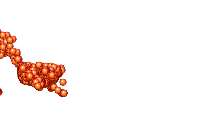

In [88]:
# Retrieve the search result
apt_feature_layer_item = search_result[0]
display(apt_feature_layer_item)

In [90]:
# Convert our existing service into a pandas dataframe
apt_layer = apt_feature_layer_item.layers[0]
apt_fset = apt_layer.query()  #querying without any conditions returns all the features
apt_df = apt_fset.df
apt_df

,FID,airport_reference_point_latitud,airport_reference_point_longitu,altim_in_hg,bulletin_time,dewpoint_c,elevation_m,elevation_m_taf,flight_category,forecasts,...,temp_c,valid_time_from,valid_time_to,vert_vis_ft,visibility_statute_mi,wind_dir_degrees,wind_gust_kt,wind_speed_kt,wx_string,SHAPE
0,1,31-28-36.2585N,082-51-38.0391W,29.958662,NaN,23.0,78.0,NaN,VFR,None,...,27.0,NaN,NaN,None,10.0,250.0,NaN,5.0,None,"{'x': -9225046.202038582, 'y': 3695244.4378803..."
1,2,32-33-53.0000N,082-59-05.9000W,29.949802,NaN,22.0,94.0,NaN,VFR,None,...,26.0,NaN,NaN,None,10.0,0.0,NaN,0.0,None,"{'x': -9237291.346025841, 'y': 3838366.757877773}"
2,3,32-12-59.0000N,083-07-43.2000W,29.958662,NaN,19.5,93.0,NaN,VFR,None,...,28.0,NaN,NaN,None,10.0,300.0,NaN,5.0,None,"{'x': -9253989.26964483, 'y': 3792223.8168781125}"
3,4,34-05-43.4000N,082-49-02.9000W,29.920275,NaN,24.4,184.0,NaN,VFR,None,...,26.3,NaN,NaN,None,7.0,280.0,NaN,5.0,None,"{'x': -9219480.227498917, 'y': 4042237.499676167}"
4,5,31-41-02.0566N,083-16-15.2531W,29.970472,NaN,24.6,111.0,NaN,VFR,None,...,28.9,NaN,NaN,None,10.0,280.0,NaN,4.0,None,"{'x': -9269573.99835589, 'y': 3721378.564195836}"
5,6,31-53-17.9015N,081-33-41.8351W,29.899607,NaN,24.8,14.0,NaN,VFR,None,...,25.5,NaN,NaN,None,10.0,220.0,NaN,4.0,None,"{'x': -9080330.864007324, 'y': 3746258.1778814..."
6,7,34-16-21.4572N,083-49-48.8040W,29.958662,NaN,23.3,386.0,NaN,VFR,None,...,25.0,NaN,NaN,None,10.0,250.0,NaN,6.0,None,"{'x': -9331912.913200123, 'y': 4065114.3047008..."
7,8,33-23-23.6600N,084-19-51.7200W,29.949802,NaN,22.8,269.0,NaN,VFR,None,...,24.5,NaN,NaN,None,10.0,250.0,NaN,4.0,None,"{'x': -9387572.65859676, 'y': 3945851.9129018546}"
8,9,31-53-06.6847N,082-38-52.4076W,29.929134,NaN,25.7,78.0,NaN,VFR,None,...,28.6,NaN,NaN,None,10.0,260.0,NaN,4.0,None,"{'x': -9200555.91406406, 'y': 3747569.049349605}"
9,10,31-03-24.8000N,082-46-31.0000W,29.949802,NaN,25.0,57.0,NaN,VFR,None,...,27.0,NaN,NaN,None,10.0,270.0,NaN,3.0,None,"{'x': -9215027.447867187, 'y': 3639244.2990106..."


In [91]:
features_for_update = []
all_features = apt_fset.features
all_features

[{"geometry": {"x": -9225046.202038582, "y": 3695244.4378803903}, "attributes": {"icao_identifier": "KDQH", "location_identifier": "DQH", "official_facility_name": "DOUGLAS MUNI", "airport_reference_point_latitud": "31-28-36.2585N", "airport_reference_point_longitu": "082-51-38.0391W", "latitude_dd": 31.4766666666667, "longitude_dd": -82.8605555555556, "altim_in_hg": 29.958662, "dewpoint_c": 23, "elevation_m": 78, "flight_category": "VFR", "latitude": 31.48, "longitude": -82.87, "metar_type": "METAR", "observation_time": 1501246500000, "precip_in": null, "quality_control_flags": "\r\n        ", "raw_text": "KDQH 281255Z AUTO 25005KT 10SM CLR 27/23 A2996 RMK AO2", "sea_level_pressure_mb": null, "sky_condition": null, "station_id": "KDQH", "temp_c": 27, "vert_vis_ft": null, "visibility_statute_mi": 10, "wind_dir_degrees": 250, "wind_gust_kt": null, "wind_speed_kt": 5, "wx_string": null, "bulletin_time": null, "elevation_m_taf": null, "forecasts": null, "issue_time": null, "latitude_taf":

In [92]:
apt_final_df.columns

Index(['location_identifier', 'official_facility_name',
       'airport_reference_point_latitude_formatted',
       'airport_reference_point_longitude_formatted', 'latitude_dd',
       'longitude_dd', 'altim_in_hg', 'dewpoint_c', 'elevation_m',
       'flight_category', 'latitude', 'longitude', 'metar_type',
       'observation_time', 'precip_in', 'quality_control_flags', 'raw_text',
       'sea_level_pressure_mb', 'sky_condition', 'station_id', 'temp_c',
       'vert_vis_ft', 'visibility_statute_mi', 'wind_dir_degrees',
       'wind_gust_kt', 'wind_speed_kt', 'wx_string', 'bulletin_time',
       'elevation_m_taf', 'forecasts', 'issue_time', 'latitude_taf',
       'longitude_taf', 'raw_text_taf', 'remarks', 'station_id_taf',
       'valid_time_from', 'valid_time_to'],
      dtype='object')

In [ ]:
from copy import deepcopy

for icao_id in apt_df['icao_identifier']:
    print("Updating {0}...".format(str(icao_id)))
    original_feature = [f for f in all_features if f.attributes['icao_identifier'] == icao_id][0]
    feature_to_be_updated = deepcopy(original_feature)
    print(original_feature)
    
    # Get the matching row from new dataframe
    matching_row = apt_final_df.loc[icao_id]
    
    # Assign the updated values
    feature_to_be_updated.attributes["location_identifier"] = matching_row['location_identifier']
    feature_to_be_updated.attributes["official_facility_name"] = matching_row['official_facility_name']
    feature_to_be_updated.attributes["airport_reference_point_latitude_formatted"] = matching_row['airport_reference_point_latitude_formatted']
    feature_to_be_updated.attributes["airport_reference_point_longitude_formatted"] = matching_row['airport_reference_point_longitude_formatted']
    feature_to_be_updated.attributes["latitude_dd"] = matching_row['latitude_dd']
    feature_to_be_updated.attributes["longitude_dd"] = matching_row['longitude_dd']
    feature_to_be_updated.attributes["metar_type"] = matching_row['metar_type']
    feature_to_be_updated.attributes["observation_time"] = matching_row['observation_time']
    feature_to_be_updated.attributes["precip_in"] = matching_row['precip_in']
    feature_to_be_updated.attributes["quality_control_flags"] = matching_row['quality_control_flags']
    feature_to_be_updated.attributes["raw_text"] = matching_row['raw_text']
    feature_to_be_updated.attributes["sea_level_pressure_mb"] = matching_row['sea_level_pressure_mb']
    feature_to_be_updated.attributes["sky_condition"] = matching_row['sky_condition']
    feature_to_be_updated.attributes["station_id"] = matching_row['station_id']
    feature_to_be_updated.attributes["temp_c"] = matching_row['temp_c']
    feature_to_be_updated.attributes["vert_vis_ft"] = matching_row['vert_vis_ft']
    feature_to_be_updated.attributes["visibility_statute_mi"] = matching_row['visibility_statute_mi']
    feature_to_be_updated.attributes["wind_dir_degrees"] = matching_row['wind_dir_degrees']
    feature_to_be_updated.attributes["wind_gust_kt"] = matching_row['wind_gust_kt']
    feature_to_be_updated.attributes["wind_speed_kt"] = matching_row['wind_speed_kt']
    feature_to_be_updated.attributes["wx_string"] = matching_row['wx_string']
    feature_to_be_updated.attributes["bulletin_time"] = matching_row['bulletin_time']
    feature_to_be_updated.attributes["elevation_m_taf"] = matching_row['elevation_m_taf']
    feature_to_be_updated.attributes["forecasts"] = matching_row['forecasts']
    feature_to_be_updated.attributes["issue_time"] = matching_row['issue_time']
    feature_to_be_updated.attributes["latitude_taf"] = matching_row['latitude_taf']
    feature_to_be_updated.attributes["longitude_taf"] = matching_row['longitude_taf']
    feature_to_be_updated.attributes["raw_text_taf"] = matching_row['raw_text_taf']
    feature_to_be_updated.attributes["remarks"] = matching_row['remarks']
    feature_to_be_updated.attributes["station_id_taf"] = matching_row['station_id_taf']
    feature_to_be_updated.attributes["valid_time_from"] = matching_row['valid_time_from']
    feature_to_be_updated.attributes["valid_time_to"] = matching_row['valid_time_to']
    break

In [ ]:
# Perform the edit using our feature_to_be_updated object
apt_layer.edit_features(updates=features_for_update)

#### Identify new features that need to be added

In [ ]:
# Select those rows in the new data that are not present in the existing data
new_rows = apt_final_df[~apt_final_df['icao_identifier'].isin()]

In [ ]:
#select those rows in the capitals_2.csv that do not overlap with those in capitals_1.csv
new_rows = cities_df_2[~cities_df_2['city_id'].isin(overlap_rows['city_id'])]
print(new_rows.shape)